In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import kagglehub
import os

In [181]:
def load_data(dataset_handle: str, file_name: str) -> pd.DataFrame:
    path = kagglehub.dataset_download(dataset_handle)    
    full_path = os.path.join(path, file_name)
    return pd.read_csv(full_path, encoding='latin1')

shots_2024 = load_data("mexwell/nba-shots", "NBA_2024_Shots.csv") # Test data
# Training data
shots_2023 = load_data("mexwell/nba-shots", "NBA_2023_Shots.csv")
shots_2022 = load_data("mexwell/nba-shots", "NBA_2022_Shots.csv")
shots_2021 = load_data("mexwell/nba-shots", "NBA_2021_Shots.csv")

In [182]:
shots_2024.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.25,1,1,8,8


In [183]:
from nba_api.stats.endpoints import leaguedashplayerstats

# Trying to add player statistics from previous seasons to see if it improves model performance
# Pull stats for the season for training data
training_season_plyr_stats = []
for i in range(2020, 2023):
    season_str = f"{i}-{str(i+1)[-2:]}"
    season_stats = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season_str,
        per_mode_detailed='PerGame'
    ).get_data_frames()[0]

    stats_to_keep = ["PLAYER_ID", "FG_PCT", "FG3_PCT", "FGM_RANK", "FG3M_RANK", "FG_PCT_RANK", "FG3_PCT_RANK"]
    season_stats = season_stats[stats_to_keep]

    training_season_plyr_stats.append(season_stats)

shots_2021 = shots_2021.merge(training_season_plyr_stats[0], on='PLAYER_ID', how='left')
shots_2022 = shots_2022.merge(training_season_plyr_stats[1], on='PLAYER_ID', how='left')
shots_2023 = shots_2023.merge(training_season_plyr_stats[2], on='PLAYER_ID', how='left')
# For the test data, we will use stats from the previous season (2022-2023). Ideally you have live data from the current season but that is not available here.
shots_2024 = shots_2024.merge(training_season_plyr_stats[2], on='PLAYER_ID', how='left')

shots_2024.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,FG_PCT,FG3_PCT,FGM_RANK,FG3M_RANK,FG_PCT_RANK,FG3_PCT_RANK
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,12,1,11,1,0.430,0.336,66.0,33.0,360.0,284.0
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,...,25,1,10,26,0.437,0.297,218.0,236.0,333.0,387.0
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,3,1,9,46,0.438,0.371,169.0,129.0,331.0,177.0
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,1,1,8,30,0.430,0.336,66.0,33.0,360.0,284.0
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,1,1,8,8,0.438,0.371,169.0,129.0,331.0,177.0


In [184]:
df = pd.concat([shots_2021, shots_2022, shots_2023, shots_2024], ignore_index=True)
df.dropna()
df["SECS_LEFT_IN_QUARTER"] = df["MINS_LEFT"] * 60 + df["SECS_LEFT"] # Doesn't matter which quarter, just need time left in quarter

# Dropping unnecessary columns
df = df.drop(columns=["GAME_ID", "PLAYER_NAME", "PLAYER_ID", "HOME_TEAM", "AWAY_TEAM", "TEAM_ID", "TEAM_NAME", "SHOT_ID",
                               "GAME_DATE", "SEASON_2", "EVENT_TYPE", "MINS_LEFT", "SECS_LEFT", "QUARTER"], errors='ignore')
df["SHOT_MADE"] = df["SHOT_MADE"].map({False : 0, True: 1})

In [185]:
# Cleaning up the data
# Use either FG_PCT or FG3M_PCT depending on shot type
cleaned_df = df.copy()
cleaned_df["PLAYER_FG_PCT"] = np.where(cleaned_df["SHOT_TYPE"] == "3PT Field Goal", cleaned_df["FG3_PCT"], cleaned_df["FG_PCT"])
# Use either FG_PCT_RANK or FG3_PCT_RANK depending on shot type
cleaned_df["PLAYER_FG_PCT_RANK"] = np.where(cleaned_df["SHOT_TYPE"] == "3PT Field Goal", cleaned_df["FG3_PCT_RANK"], cleaned_df["FG_PCT_RANK"])
# Use either FGM_RANK or FG3M_RANK depending on shot type
cleaned_df["PLAYER_FG_MADE_RANK"] = np.where(cleaned_df["SHOT_TYPE"] == "3PT Field Goal", cleaned_df["FG3M_RANK"], cleaned_df["FGM_RANK"])
# Drop the now redundant columns
cleaned_df = cleaned_df.drop(columns=["FG_PCT", "FG3_PCT", "SHOT_TYPE", "FGM_RANK", "FG3M_RANK", "FG_PCT_RANK", "FG3_PCT_RANK"], errors='ignore')
# Can also drop zone columns as they are redundant with LOC_X and LOC_Y 
cleaned_df = cleaned_df.drop(columns=["BASIC_ZONE", "ZONE_ABB", "ZONE_RANGE"], errors='ignore')
cleaned_df.head()


,SEASON_1,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,ZONE_NAME,LOC_X,LOC_Y,SHOT_DISTANCE,SECS_LEFT_IN_QUARTER,PLAYER_FG_PCT,PLAYER_FG_PCT_RANK,PLAYER_FG_MADE_RANK
0,2021,G,PG,0,Jump Shot,Left Side,-2.31,5.995,23,15,0.337,271.0,178.0
1,2021,G,PG,0,Pullup Jump shot,Left Side Center,-1.75,7.925,27,20,0.337,271.0,178.0
2,2021,F,PF,1,Driving Layup Shot,Center,-0.24,5.965,3,24,0.538,72.0,396.0
3,2021,G,PG,1,Step Back Jump shot,Right Side Center,1.45,7.975,26,41,0.337,271.0,178.0
4,2021,F,SF,0,Tip Dunk Shot,Center,-0.00,5.775,0,25,0.318,506.0,514.0


In [186]:
# Split into training and test sets
training_df = cleaned_df[cleaned_df["SEASON_1"] != 2024]
test_df = cleaned_df[cleaned_df["SEASON_1"] == 2024]
training_df = training_df.drop(columns=["SEASON_1"])
test_df = test_df.drop(columns=["SEASON_1"])
print(training_df.shape)
print(training_df.head())
league_avg_fg_pct = training_df['SHOT_MADE'].mean()

(624925, 12)
  POSITION_GROUP POSITION  SHOT_MADE          ACTION_TYPE          ZONE_NAME  \
0              G       PG          0            Jump Shot          Left Side   
1              G       PG          0     Pullup Jump shot   Left Side Center   
2              F       PF          1   Driving Layup Shot             Center   
3              G       PG          1  Step Back Jump shot  Right Side Center   
4              F       SF          0        Tip Dunk Shot             Center   

   LOC_X  LOC_Y  SHOT_DISTANCE  SECS_LEFT_IN_QUARTER  PLAYER_FG_PCT  \
0  -2.31  5.995             23                    15          0.337   
1  -1.75  7.925             27                    20          0.337   
2  -0.24  5.965              3                    24          0.538   
3   1.45  7.975             26                    41          0.337   
4  -0.00  5.775              0                    25          0.318   

   PLAYER_FG_PCT_RANK  PLAYER_FG_MADE_RANK  
0               271.0             

In [187]:
print(test_df.shape)
print(test_df.head())

(218701, 12)
       POSITION_GROUP POSITION  SHOT_MADE                     ACTION_TYPE  \
624925              G       SG          0      Driving Floating Jump Shot   
624926              F       SF          1                       Jump Shot   
624927              G       PG          1              Driving Layup Shot   
624928              G       SG          1  Running Finger Roll Layup Shot   
624929              G       PG          1              Cutting Layup Shot   

       ZONE_NAME  LOC_X  LOC_Y  SHOT_DISTANCE  SECS_LEFT_IN_QUARTER  \
624925    Center   -0.4  17.45             12                   661   
624926    Center    1.5  30.55             25                   626   
624927    Center   -3.3   6.55              3                   586   
624928    Center   -1.0   5.85              1                   510   
624929    Center   -0.0   6.25              1                   488   

        PLAYER_FG_PCT  PLAYER_FG_PCT_RANK  PLAYER_FG_MADE_RANK  
624925          0.430           

In [188]:
# Using random forest classifier to determine feature importance
from sklearn.model_selection import train_test_split

categorical_cols = training_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    training_df[col] = training_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

X = training_df.drop(columns=["SHOT_MADE"])
y = training_df["SHOT_MADE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Using lightGBM to get information gain for each column
model = lgb.LGBMClassifier(importance_type='gain')
model.fit(X_train, y_train)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Feature Importances from LGBM Classifier:
                 Feature     Importance
6          SHOT_DISTANCE  169543.522456
2            ACTION_TYPE  111311.138493
8          PLAYER_FG_PCT   28531.193706
7   SECS_LEFT_IN_QUARTER    7211.112883
9     PLAYER_FG_PCT_RANK    5254.918128
10   PLAYER_FG_MADE_RANK    4213.474838
5                  LOC_Y    3689.655642
4                  LOC_X    2997.913235
1               POSITION    1110.238748
3              ZONE_NAME     825.369359
0         POSITION_GROUP     100.933110


Text(0.5, 1.0, 'Feature Importances from LGBM Classifier')

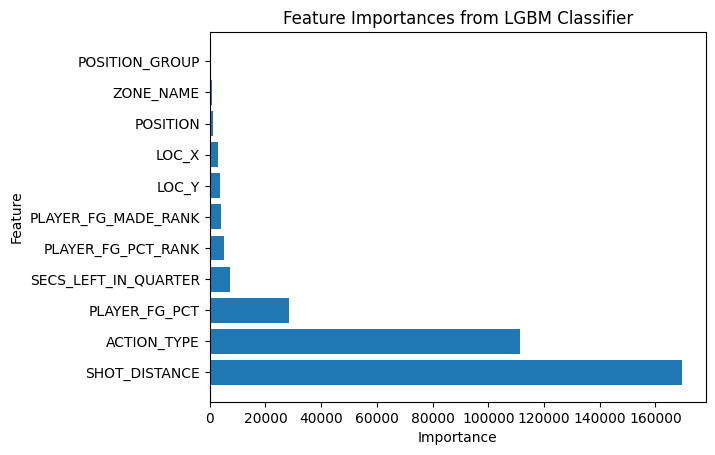

In [189]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from LGBM Classifier:")
print(importance_df)

# Plotting feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Classifier')

Permutation Importances from Random Forest Classifier:
                 Feature  Importance
2            ACTION_TYPE    0.058050
6          SHOT_DISTANCE    0.046582
8          PLAYER_FG_PCT    0.004477
5                  LOC_Y    0.001787
4                  LOC_X    0.000837
10   PLAYER_FG_MADE_RANK    0.000528
3              ZONE_NAME    0.000240
1               POSITION    0.000184
9     PLAYER_FG_PCT_RANK    0.000173
7   SECS_LEFT_IN_QUARTER    0.000144
0         POSITION_GROUP   -0.000026


Text(0.5, 1.0, 'Permutation Importances from Random Forest Classifier')

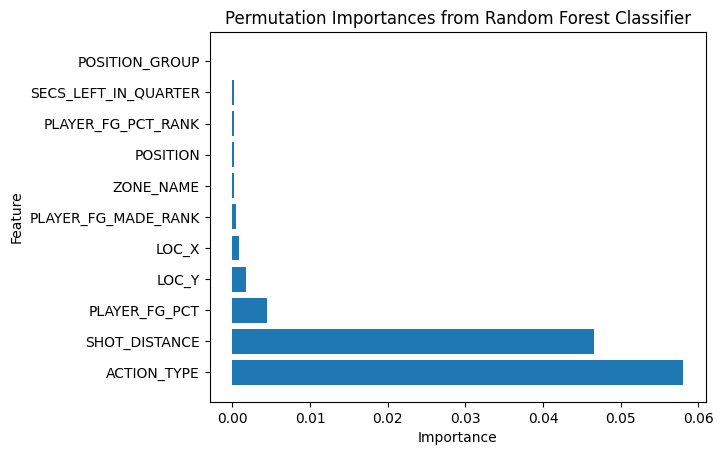

In [190]:
from sklearn.inspection import permutation_importance

# Checking permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Permutation Importances from Random Forest Classifier:")
print(importance_df)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances from Random Forest Classifier')

From the plots, we can eliminate features that have very low importance scores and low permutation importance. This will help in reducing the dimensionality of the dataset and potentially improve model performance. These features are POSITION_GROUP, ZONE_NAME and POSITION. SECS_LEFT_IN_QUARTER shows moderate importance but negative permutation importance. Further analysis is needed to decide whether to keep or remove this feature.

Correlation between SECS_LEFT_IN_QUARTER and SHOT_MADE: 0.01690904185983072


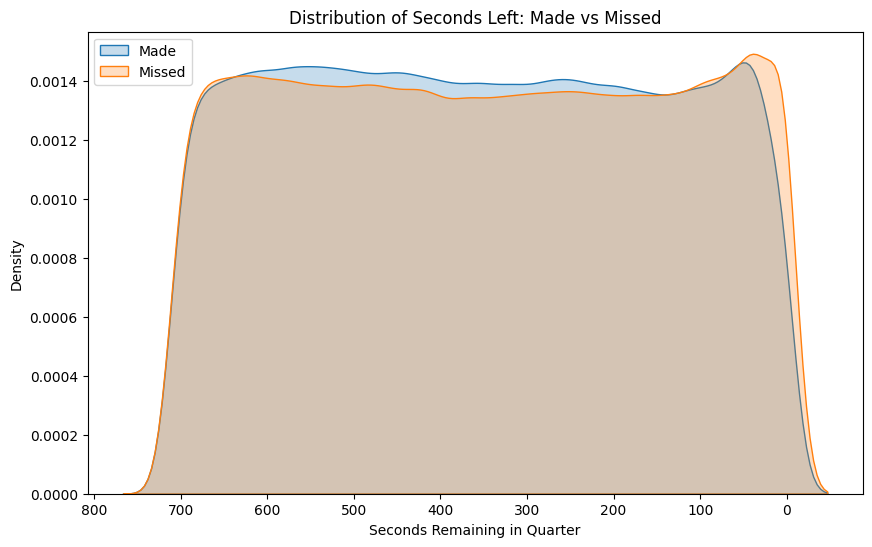

In [191]:
coeff = np.corrcoef(cleaned_df['SECS_LEFT_IN_QUARTER'], cleaned_df['SHOT_MADE'])[0, 1]
print(f"Correlation between SECS_LEFT_IN_QUARTER and SHOT_MADE: {coeff}") # Shows a weak correlation, let us graph it to see if it reveals any patterns
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['SHOT_MADE'] == 1]['SECS_LEFT_IN_QUARTER'], label='Made', fill=True)
sns.kdeplot(data=df[df['SHOT_MADE'] == 0]['SECS_LEFT_IN_QUARTER'], label='Missed', fill=True)
plt.title('Distribution of Seconds Left: Made vs Missed')
plt.xlabel('Seconds Remaining in Quarter')
plt.gca().invert_xaxis() 
plt.legend()
plt.show()

From the density plot, we can see that this feature does not have a strong influence on whether a shot is made or missed during most of the quarter, however there is a spike in missed field goals as the quarter nears its end.

In [192]:
# let us engineer a new feature based the seconds left in the quarter
time_pressure_df = training_df.copy()
# Let time pressure be defined as having 24 or fewer seconds left in the quarter
time_pressure_df['TIME_PRESSURE'] = np.where(time_pressure_df['SECS_LEFT_IN_QUARTER'] <= 24, 1, 0)
shots_made_by_time_pressure = time_pressure_df.groupby('TIME_PRESSURE')['SHOT_MADE'].sum()
shots_taken_by_time_pressure = time_pressure_df['TIME_PRESSURE'].value_counts().sort_index()
fg_pct_by_time_pressure = shots_made_by_time_pressure / shots_taken_by_time_pressure
print("Field Goal Percentage with and without Time Pressure:")
print(fg_pct_by_time_pressure)

Field Goal Percentage with and without Time Pressure:
TIME_PRESSURE
0    0.471867
1    0.371150
dtype: float64


In [193]:
# FG% drops 10 points when there is time pressure, indicating this may be a useful feature
training_df['TIME_PRESSURE'] = np.where(training_df['SECS_LEFT_IN_QUARTER'] <= 24, 1, 0)

C:\Users\sathv\AppData\Local\Temp\ipykernel_62592\328362925.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shot_stats = shot_df.groupby('DIST_BIN')['SHOT_MADE'].agg(['sum', 'count'])


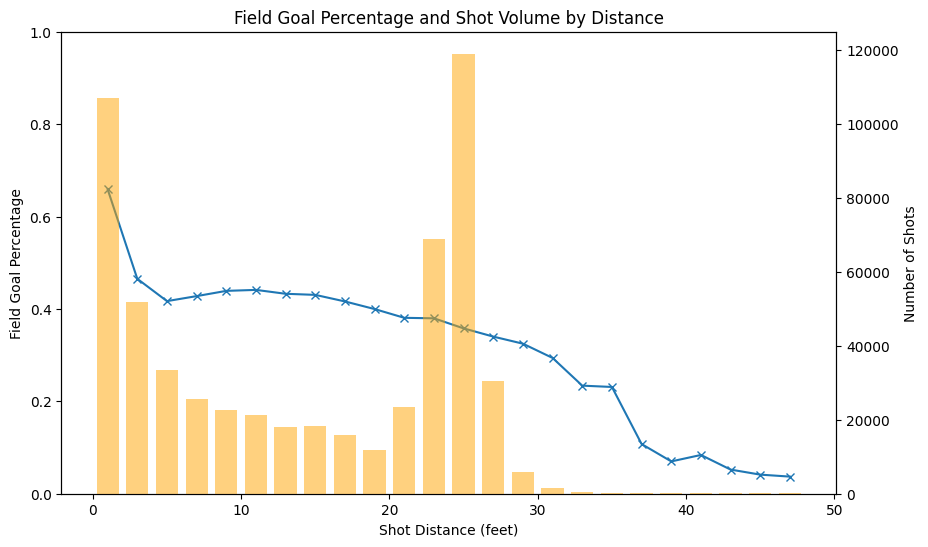

In [194]:
# Examine relation between shot distance and shot made
shot_df = training_df[['SHOT_DISTANCE', 'SHOT_MADE']].copy()
bins = np.arange(0, 50, 2)
shot_df['DIST_BIN'] = pd.cut(shot_df['SHOT_DISTANCE'], bins)
shot_stats = shot_df.groupby('DIST_BIN')['SHOT_MADE'].agg(['sum', 'count'])
shot_stats['FG_PCT'] = shot_stats['sum'] / shot_stats['count']

bin_centers = [interval.mid for interval in shot_stats.index]
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(bin_centers, shot_stats['FG_PCT'], marker='x')
ax1.set_ylim(0, 1)
ax1.set_xlabel('Shot Distance (feet)')
ax1.set_ylabel('Field Goal Percentage')

ax2 = ax1.twinx()
ax2.bar(bin_centers, shot_stats['count'], color='orange', width=1.5, alpha=0.5)
ax2.set_ylabel('Number of Shots')
plt.title('Field Goal Percentage and Shot Volume by Distance')
plt.show()

FG% constantly decreases non-linearly as distance from the basket increases, which is expected.

In [195]:
# Let us engineer some new features to model the non-linear relationship between shot distance and shot made
training_df['SHOT_DIST_SQ'] = training_df['SHOT_DISTANCE'] ** 2
test_df['SHOT_DIST_SQ'] = test_df['SHOT_DISTANCE'] ** 2
training_df['SHOT_DIST_LOG'] = np.log1p(training_df['SHOT_DISTANCE'])
test_df['SHOT_DIST_LOG'] = np.log1p(test_df['SHOT_DISTANCE'])
training_df.head()      

,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,ZONE_NAME,LOC_X,LOC_Y,SHOT_DISTANCE,SECS_LEFT_IN_QUARTER,PLAYER_FG_PCT,PLAYER_FG_PCT_RANK,PLAYER_FG_MADE_RANK,TIME_PRESSURE,SHOT_DIST_SQ,SHOT_DIST_LOG
0,G,PG,0,Jump Shot,Left Side,-2.31,5.995,23,15,0.337,271.0,178.0,1,529,3.178054
1,G,PG,0,Pullup Jump shot,Left Side Center,-1.75,7.925,27,20,0.337,271.0,178.0,1,729,3.332205
2,F,PF,1,Driving Layup Shot,Center,-0.24,5.965,3,24,0.538,72.0,396.0,1,9,1.386294
3,G,PG,1,Step Back Jump shot,Right Side Center,1.45,7.975,26,41,0.337,271.0,178.0,0,676,3.295837
4,F,SF,0,Tip Dunk Shot,Center,-0.00,5.775,0,25,0.318,506.0,514.0,0,0,0.000000


In [196]:
print(training_df['ACTION_TYPE'].unique().tolist())
# There are 48 different action types, let us group them into broader categories
action = training_df['ACTION_TYPE']

# Used AI to define these groups
conditions = [
   action.str.contains('Dunk', case=False),
   action.str.contains('Layup', case=False),
   action.str.contains('Hook', case=False),
   action.str.contains('Turnaround|Fadeaway', case=False),
   action.str.contains('Pullup|Step Back|Floating', case=False),
   action.str.contains('Jump Shot|Jump Bank Shot', case=False)
]

choices = [
    'Dunk', 
    'Layup', 
    'Hook', 
    'Turnaround_Fadeaway', 
    'Off Dribble', 
    'Standard_Jumper'
]

training_df['ACTION_TYPE_GROUP'] = np.select(conditions, choices, default='Other')
training_df['ACTION_TYPE_GROUP'] = training_df['ACTION_TYPE_GROUP'].astype('category')
training_df = training_df.drop(columns=["ACTION_TYPE"])
training_df.head()

['Jump Shot', 'Pullup Jump shot', 'Driving Layup Shot', 'Step Back Jump shot', 'Tip Dunk Shot', 'Running Reverse Layup Shot', 'Cutting Dunk Shot', 'Driving Hook Shot', 'Cutting Layup Shot', 'Putback Layup Shot', 'Driving Finger Roll Layup Shot', 'Driving Reverse Layup Shot', 'Running Layup Shot', 'Driving Floating Jump Shot', 'Tip Layup Shot', 'Turnaround Hook Shot', 'Turnaround Jump Shot', 'Turnaround Fadeaway Bank Jump Shot', 'Running Dunk Shot', 'Layup Shot', 'Hook Shot', 'Jump Bank Shot', 'Dunk Shot', 'Floating Jump shot', 'Hook Bank Shot', 'Turnaround Fadeaway shot', 'Alley Oop Dunk Shot', 'Driving Floating Bank Jump Shot', 'Fadeaway Jump Shot', 'Running Jump Shot', 'Turnaround Bank Hook Shot', 'Putback Dunk Shot', 'Reverse Layup Shot', 'Alley Oop Layup shot', 'Running Finger Roll Layup Shot', 'Reverse Dunk Shot', 'Driving Dunk Shot', 'Running Pull-Up Jump Shot', 'Cutting Finger Roll Layup Shot', 'Running Alley Oop Dunk Shot', 'Running Reverse Dunk Shot', 'Running Alley Oop Layup 

,POSITION_GROUP,POSITION,SHOT_MADE,ZONE_NAME,LOC_X,LOC_Y,SHOT_DISTANCE,SECS_LEFT_IN_QUARTER,PLAYER_FG_PCT,PLAYER_FG_PCT_RANK,PLAYER_FG_MADE_RANK,TIME_PRESSURE,SHOT_DIST_SQ,SHOT_DIST_LOG,ACTION_TYPE_GROUP
0,G,PG,0,Left Side,-2.31,5.995,23,15,0.337,271.0,178.0,1,529,3.178054,Standard_Jumper
1,G,PG,0,Left Side Center,-1.75,7.925,27,20,0.337,271.0,178.0,1,729,3.332205,Off Dribble
2,F,PF,1,Center,-0.24,5.965,3,24,0.538,72.0,396.0,1,9,1.386294,Layup
3,G,PG,1,Right Side Center,1.45,7.975,26,41,0.337,271.0,178.0,0,676,3.295837,Off Dribble
4,F,SF,0,Center,-0.00,5.775,0,25,0.318,506.0,514.0,0,0,0.000000,Dunk


C:\Users\sathv\AppData\Local\Temp\ipykernel_62592\3577649466.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = training_df.groupby('ACTION_TYPE_GROUP')['SHOT_MADE'].mean().reset_index()


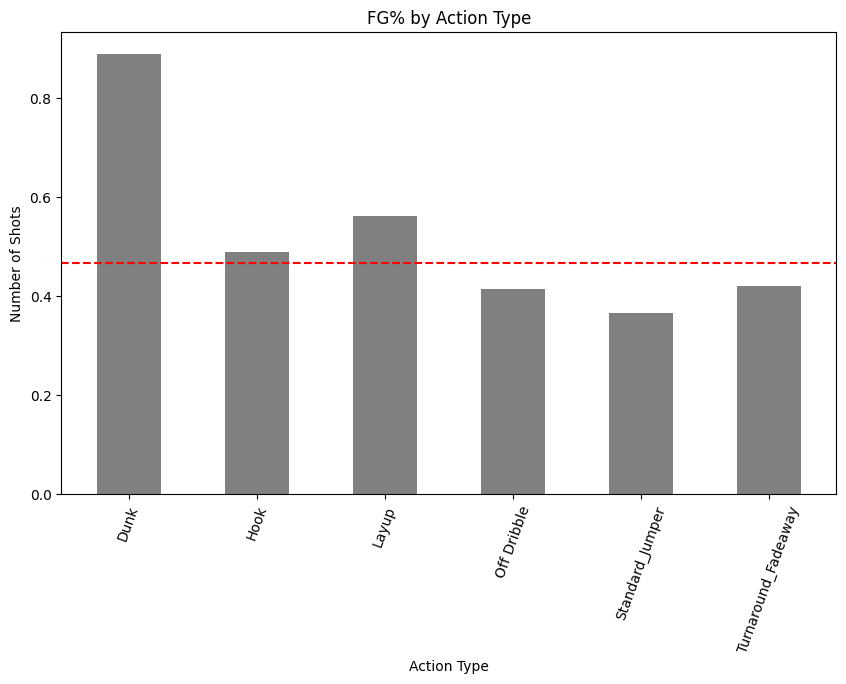

In [197]:
# Let us plot shot made vs missed by action type group
plt.figure(figsize=(10, 6))
summary = training_df.groupby('ACTION_TYPE_GROUP')['SHOT_MADE'].mean().reset_index()
plt.bar(summary['ACTION_TYPE_GROUP'], summary['SHOT_MADE'], width=0.5, color = ['gray'])
plt.axhline(y=league_avg_fg_pct, color='red', linestyle='--', label='League Avg FG%')
plt.title('FG% by Action Type')
plt.xlabel('Action Type')
plt.xticks(rotation=70)
plt.ylabel('Number of Shots')
plt.show()

In [198]:
action = test_df['ACTION_TYPE']
conditions = [
   action.str.contains('Dunk', case=False),
   action.str.contains('Layup', case=False),
   action.str.contains('Hook', case=False),
   action.str.contains('Turnaround|Fadeaway', case=False),
   action.str.contains('Pullup|Step Back|Floating', case=False),
   action.str.contains('Jump Shot|Jump Bank Shot', case=False)
]
choices = [
    'Dunk', 
    'Layup', 
    'Hook', 
    'Turnaround_Fadeaway', 
    'Off Dribble', 
    'Standard_Jumper'
]
test_df['ACTION_TYPE_GROUP'] = np.select(conditions, choices, default='Other')
test_df = test_df.drop(columns=["ACTION_TYPE"])
test_df['ACTION_TYPE_GROUP'] = test_df['ACTION_TYPE_GROUP'].astype('category')
print(test_df.head())

       POSITION_GROUP POSITION  SHOT_MADE ZONE_NAME  LOC_X  LOC_Y  \
624925              G       SG          0    Center   -0.4  17.45   
624926              F       SF          1    Center    1.5  30.55   
624927              G       PG          1    Center   -3.3   6.55   
624928              G       SG          1    Center   -1.0   5.85   
624929              G       PG          1    Center   -0.0   6.25   

        SHOT_DISTANCE  SECS_LEFT_IN_QUARTER  PLAYER_FG_PCT  \
624925             12                   661          0.430   
624926             25                   626          0.297   
624927              3                   586          0.438   
624928              1                   510          0.430   
624929              1                   488          0.438   

        PLAYER_FG_PCT_RANK  PLAYER_FG_MADE_RANK  SHOT_DIST_SQ  SHOT_DIST_LOG  \
624925               360.0                 66.0           144       2.564949   
624926               387.0                236.0     

Some shot categories have higher than league average FG% while others are significantly lower.

In [199]:
# Retrain model with new features
categorical_cols = training_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    training_df[col] = training_df[col].astype('category')

X = training_df.drop(columns=["SHOT_MADE"])
y = training_df["SHOT_MADE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Using lightGBM to get information gain for each column
model = lgb.LGBMClassifier(importance_type='gain')
model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Feature Importances from LGBM Classifier:
                 Feature     Importance
5          SHOT_DISTANCE  187171.192083
13     ACTION_TYPE_GROUP   56670.786031
7          PLAYER_FG_PCT   29286.557324
6   SECS_LEFT_IN_QUARTER    7774.800223
3                  LOC_X    5972.699989
8     PLAYER_FG_PCT_RANK    4502.144185
9    PLAYER_FG_MADE_RANK    4386.173419
4                  LOC_Y    4169.286990
1               POSITION    1604.165811
2              ZONE_NAME     864.594061
0         POSITION_GROUP     163.193840
10         TIME_PRESSURE       0.000000
11          SHOT_DIST_SQ       0.000000
12         SHOT_DIST_LOG       0.000000


Text(0.5, 1.0, 'Feature Importances from LGBM Classifier')

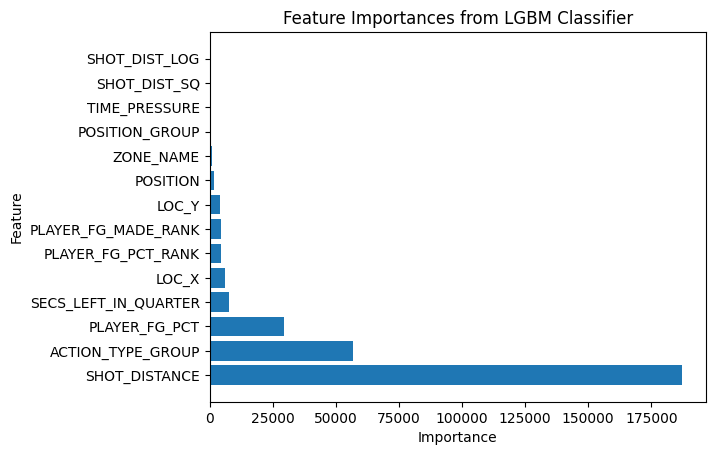

In [200]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from LGBM Classifier:")
print(importance_df)

# Plotting feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Classifier')

Permutation Importances from Random Forest Classifier:
                 Feature  Importance
5          SHOT_DISTANCE    0.063230
13     ACTION_TYPE_GROUP    0.012944
7          PLAYER_FG_PCT    0.006199
9    PLAYER_FG_MADE_RANK    0.001181
4                  LOC_Y    0.000714
1               POSITION    0.000638
2              ZONE_NAME    0.000446
6   SECS_LEFT_IN_QUARTER    0.000323
8     PLAYER_FG_PCT_RANK    0.000307
3                  LOC_X    0.000040
0         POSITION_GROUP    0.000013
10         TIME_PRESSURE    0.000000
11          SHOT_DIST_SQ    0.000000
12         SHOT_DIST_LOG    0.000000


Text(0.5, 1.0, 'Permutation Importances from Random Forest Classifier')

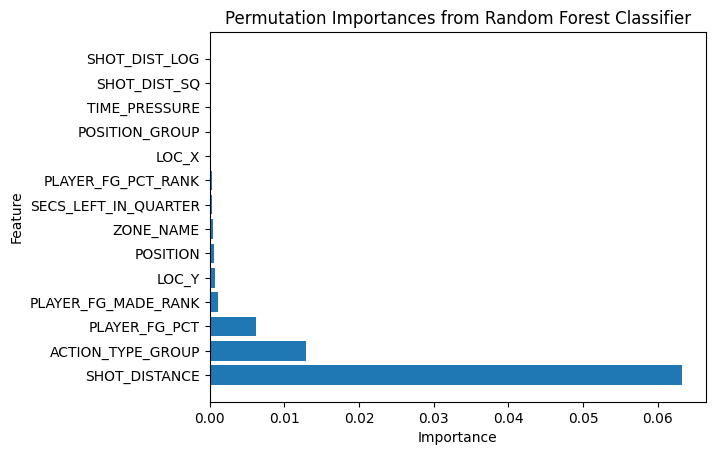

In [201]:
from sklearn.inspection import permutation_importance

# Checking permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Permutation Importances from Random Forest Classifier:")
print(importance_df)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances from Random Forest Classifier')

Unfortunately, neither SECS_LEFT_IN_QUARTER nor TIME_PRESSURE appear in the top features from the LightGBM model, indicating that these features may not be as predictive as initially thought. While SHOT_DISTANCE and ACTION_TYPE_GROUP continue to show strong predictive power, suggesting that shot distance and type are more critical factors in determining shot success than time-related features.

In [202]:
columns_to_drop = ["POSITION_GROUP", "ZONE_NAME", "POSITION", "SECS_LEFT_IN_QUARTER", "TIME_PRESSURE", "SHOT_DIST_SQ", "SHOT_DIST_LOG"]
training_df = training_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')
print(training_df.head())
print(test_df.head())

   SHOT_MADE  LOC_X  LOC_Y  SHOT_DISTANCE  PLAYER_FG_PCT  PLAYER_FG_PCT_RANK  \
0          0  -2.31  5.995             23          0.337               271.0   
1          0  -1.75  7.925             27          0.337               271.0   
2          1  -0.24  5.965              3          0.538                72.0   
3          1   1.45  7.975             26          0.337               271.0   
4          0  -0.00  5.775              0          0.318               506.0   

   PLAYER_FG_MADE_RANK ACTION_TYPE_GROUP  
0                178.0   Standard_Jumper  
1                178.0       Off Dribble  
2                396.0             Layup  
3                178.0       Off Dribble  
4                514.0              Dunk  
        SHOT_MADE  LOC_X  LOC_Y  SHOT_DISTANCE  PLAYER_FG_PCT  \
624925          0   -0.4  17.45             12          0.430   
624926          1    1.5  30.55             25          0.297   
624927          1   -3.3   6.55              3          0.438   
6

In [203]:
# Shuffling the data
training_df = training_df.sample(frac = 1).reset_index(drop=True)
test_df = test_df.sample(frac = 1).reset_index(drop=True)

X = training_df.drop(columns=["SHOT_MADE"])
y = training_df["SHOT_MADE"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 
X_test = test_df.drop(columns=["SHOT_MADE"])
y_test = test_df["SHOT_MADE"]

In [204]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'num_leaves': 128,
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'scale_pos_weight': 1.15,
    'lambda_l1': 2.0,
    'feature_fraction': 0.8,
    'verbosity': -1
}

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

model = lgb.LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's binary_logloss: 0.639914


,Feature,Importance
0,LOC_X,13047
1,LOC_Y,12198
5,PLAYER_FG_MADE_RANK,11690
3,PLAYER_FG_PCT,10434
4,PLAYER_FG_PCT_RANK,7861
2,SHOT_DISTANCE,7050
6,ACTION_TYPE_GROUP,2963


In [205]:
from sklearn.metrics import classification_report, accuracy_score, log_loss, precision_recall_curve

# Evaluate model performance
y_prob = model.predict_proba(X_test)[:, 1]

# Get optimal threshold
optimal_threshold = league_avg_fg_pct
print(f"Optimal Threshold: {optimal_threshold:.4f}")

y_pred = (y_prob >= optimal_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log Loss: {log_loss(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Optimal Threshold: 0.4676
Accuracy: 0.6079
Log Loss: 0.6746

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64    114962
           1       0.59      0.55      0.57    103739

    accuracy                           0.61    218701
   macro avg       0.61      0.60      0.60    218701
weighted avg       0.61      0.61      0.61    218701



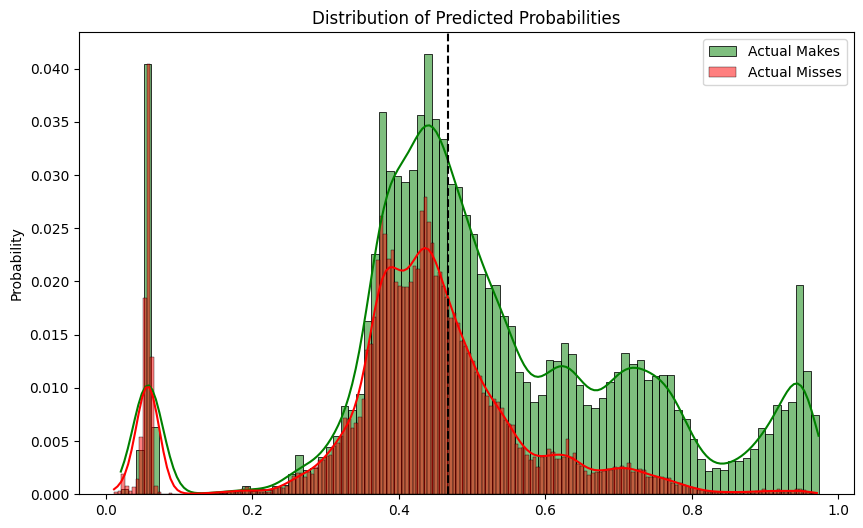

In [206]:
plt.figure(figsize=(10, 6))
sns.histplot(y_prob[y_test == 1], color='green', label='Actual Makes', kde=True, stat="probability")
sns.histplot(y_prob[y_test == 0], color='red', label='Actual Misses', kde=True, stat="probability")
plt.axvline(optimal_threshold, color='black', linestyle='--')
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()

From the graph, we can see that the model is missing a lot of makes. Since we would rather have higher recall (fewer missed shots) even at the cost of precision (more false alarms), we can adjust the classification threshold to improve recall.

Best Threshold: 0.4627
AUC: 0.6456
Accuracy: 0.6054
Log Loss: 0.6746

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63    114962
           1       0.59      0.56      0.58    103739

    accuracy                           0.61    218701
   macro avg       0.60      0.60      0.60    218701
weighted avg       0.60      0.61      0.60    218701



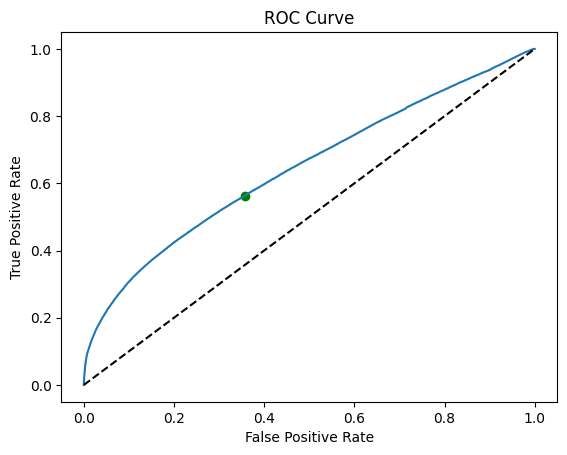

In [217]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = auc(fpr, tpr)

distance_to_optimal = np.sqrt((fpr)**2 + (1 - tpr)**2)
best_idx = np.argmin(distance_to_optimal)
optimal_threshold = thresholds[best_idx]

print(f"Best Threshold: {optimal_threshold:.4f}")
print(f"AUC: {auc:.4f}")

plt.scatter(fpr[best_idx], tpr[best_idx], color='green')
plt.plot(fpr, tpr, label='LGBM Classifier')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

y_pred = (y_prob >= optimal_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log Loss: {log_loss(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Threshold adjustment made no difference. Further feature engineering and model tuning is needed to improve performance.